# SQP Multistart
This notebook is a short example showing how to solve a global optimization problem with the NAG SQP solver with multiple starting points.

We will minimize Himmelblau's function:
$$
\min_{x,y} (x^2 + y - 11)^2 + (x + y^2 - 7)^2\\
-5 \leq x, y \leq 5
$$

We can start by ploting the function on the feasible domain using matplotlib:

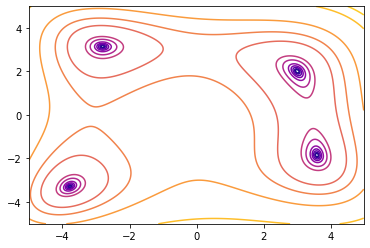

In [1]:
# Select the display backend for Jupyter:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)
X, Y = np.meshgrid(np.arange(-5.,5.,0.02), np.arange(-5.,5.,0.02))
Z = (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2
lev = [0.1, 0.2, 0.5, 1., 2., 5., 10., 50., 100., 200., 500., 700., 1000., 2000.]
ax.contour(X, Y, Z, levels=lev, norm=LogNorm(), cmap=cm.plasma)
plt.show()

We can see this function has four local minima in the feasible doamin, all with a function value of 0.0.

We can now define the actual model that will be solved by the solver:

In [2]:
# bounds on the variables
bl = [-5., -5.]
bu = [5., 5.]
# Number of variables 
n = 2
# number of solutions required
nb = 4
# number of starting points
npts = 6

# parameters controlling the linear and nonlinear constraints (only simple bounds are defined in the model)
ncnln = 0
repeat = False


In [3]:
# user data to be passed to the objective function callback
class usr_data:
    def __init__(self):
        self.npts = 0
        self.pts = []
        
def objfun(mode, x, objgrd, nstate, data=None):
    # Himmelblau's function
    objf = (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2
    if mode > 0:
        objgrd[0] = 4*x[0]*(x[0]**2 + x[1] - 11) + 2*(x[0] + x[1]**2 - 7)
        objgrd[1] = 2*(x[0]**2 + x[1] - 11) + 4*x[1]*(x[0] + x[1]**2 - 7)
    
    if data is not None:
        # record the objective evaluations every two calls to objfun
        data.npts += 1
        data.pts.append((x[0], x[1]))
    return objf, objgrd

In [4]:
from naginterfaces.base import utils
from naginterfaces.library import glopt
import warnings 

# initialize the user data, I/O and options
data = usr_data()
iom = utils.FileObjManager(locus_in_output=False)
warnings.simplefilter("error", utils.NagAlgorithmicWarning)
comm = {}
glopt.optset('Initialize = nlp_multistart_sqp', comm, io_manager=iom)
nsol = nb

# call the solver
try:
    sln = glopt.nlp_multistart_sqp(
        n, ncnln, bl, bu, objfun, npts, repeat, nb, comm, data=data, 
        io_manager=None,
    )
except utils.NagAlgorithmicWarning as ex:
    if ex.errno == 8:
        sln = ex.return_data
        nsol = sln.info[nb-1]
    else:
        raise ex

print(nsol, 'solutions were found\n')

print('The', nsol, 'computed solutions are:')
for j in range(nsol):
    print("points coordinate: %6.3f, %6.3f, objective value: %6.3f"% (sln.x[0][j], sln.x[1][j], sln.objf[j]))

4 solutions were found

The 4 computed solutions are:
points coordinate: -2.805,  3.131, objective value:  0.000
points coordinate: -3.779, -3.283, objective value:  0.000
points coordinate:  3.584, -1.848, objective value:  0.000
points coordinate:  3.000,  2.000, objective value:  0.000


To visualize the points evaluated, let's plot again the level set of the function and add a scatter plot of the list of points requested by the solver:

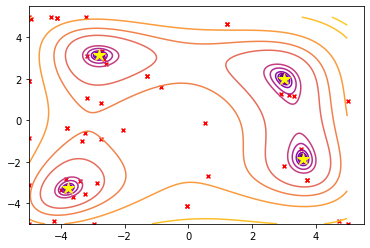

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contour(X, Y, Z, levels=lev, norm=LogNorm(), cmap=cm.plasma)
ax.scatter(*zip(*data.pts), s=15, marker='x', c='red')
for j in range(nsol):
    ax.plot(sln.x[0][j], sln.x[1][j], markersize=12, marker='*', c='yellow')
plt.show()